In this notebook, we examine with the variances of the gradient estimators described in experimenting_arm.ipynb

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import bernoulli_experiments_lib as arm_lib

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical

import itertools

In [3]:
softmax = nn.Softmax(dim = 0)

sigmoid = nn.Sigmoid()

In [4]:
np.random.seed(454)
_ = torch.manual_seed(454)

In [5]:
# fixed parameters
d = 3
# p0 = torch.rand(d)
p0 = torch.Tensor([0.6, 0.51, 0.48])
print('p0: ', p0, '\n')

print('sum(p0^2): ', torch.sum(p0**2))
print('sum((1 - p0)^2): ', torch.sum((1 - p0)**2), '\n')

# the optima
x_optimal = torch.argmin(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

optimal_loss = torch.min(torch.Tensor([torch.sum(p0**2), torch.sum((1 - p0)**2)]))

print('optimal loss: ', optimal_loss)
print('optimal x: ', x_optimal.numpy())

p0:  tensor([ 0.6000,  0.5100,  0.4800]) 

sum(p0^2):  tensor(0.8505)
sum((1 - p0)^2):  tensor(0.6705) 

optimal loss:  tensor(0.6705)
optimal x:  1


In [6]:
# random init for phi
phi0 = torch.Tensor([0.0])
phi0.requires_grad_(True)
print('init phi0: ', phi0)
print('init e_b: ', sigmoid(phi0))

init phi0:  tensor([ 0.])
init e_b:  tensor([ 0.5000])


In [7]:
params = [phi0]
optimizer = optim.SGD(params, lr = 1.0)

# True gradient

In [8]:
optimizer.zero_grad()

In [9]:
loss = arm_lib.get_loss(phi0, p0)

In [10]:
loss.backward()

In [11]:
true_grad = deepcopy(phi0.grad)
print(true_grad)

tensor(1.00000e-02 *
       [-4.5000])


In [12]:
# Function to sample the gradient from a given estimator 

def sample_gradient(phi0, p0, get_ps_loss, n_samples = 10000):
    params = [phi0]
    optimizer = optim.SGD(params, lr = 1.0)

    grad_array = torch.zeros(n_samples)
    for i in range(n_samples): 
        optimizer.zero_grad()
        ps_loss = get_ps_loss(phi0, p0)
        ps_loss.backward()
        grad_array[i] = phi0.grad
    
    return grad_array

# Reinforce gradient

In [13]:
n_samples = 100000
reinforce_grads = sample_gradient(phi0, p0, arm_lib.get_reinforce_ps_loss, n_samples = n_samples)

In [14]:
print('true_grad: ', true_grad.numpy())
print('mean reinforce grad: ', torch.mean(reinforce_grads).numpy())
print('variance: ', torch.var(reinforce_grads).numpy())

print('scaled error: ', (torch.std(reinforce_grads) / np.sqrt(n_samples) * 3).numpy())

true_grad:  [-0.045]
mean reinforce grad:  -0.043299273
variance:  0.4400076
scaled error:  0.0062929075


Text(0.5,0,'reinforce gradients')

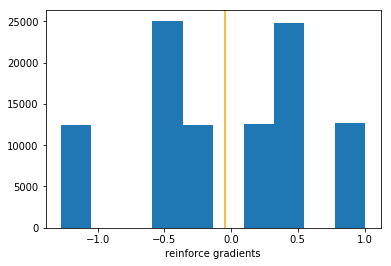

In [15]:
plt.hist(reinforce_grads)
plt.axvline(x=true_grad, color = 'orange') # true gradient 

plt.xlabel('reinforce gradients')

# Arm gradient

In [16]:
n_samples = 10000
arm_grads = sample_gradient(phi0, p0, arm_lib.get_arm_ps_loss, n_samples = n_samples)

In [17]:
print('true_grad: ', true_grad.numpy())
print('mean reinforce grad: ', torch.mean(arm_grads).numpy())
print('variance: ', torch.var(arm_grads).numpy())

print('scaled error: ', (torch.std(arm_grads) / np.sqrt(n_samples) * 3).numpy())

true_grad:  [-0.045]
mean reinforce grad:  -0.044760834
variance:  0.0073505454
scaled error:  0.0025720596


Text(0.5,0,'arm gradients')

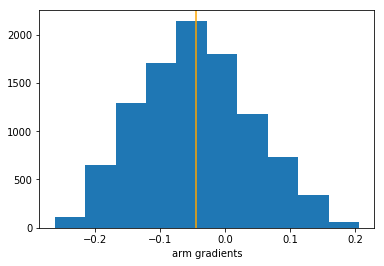

In [18]:
plt.hist(arm_grads)
plt.axvline(x=true_grad, color = 'orange') # true gradient 

plt.xlabel('arm gradients')

# Mix reinforce and Classic

In [19]:
n_samples = 10000

mixed_grads_array = torch.zeros((2**d - 1, n_samples))

for i in range(1, 2**d): 
    print(i)
    mixed_grads_array[i-1, :] = sample_gradient(phi0, p0, 
                                  lambda phi0, p0 : arm_lib.get_mixed_reinforce_ps_loss(phi0, p0, i), 
                                  n_samples = n_samples)

1
2
3
4
5
6
7


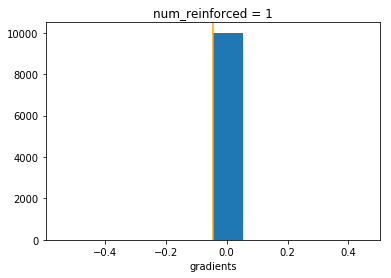

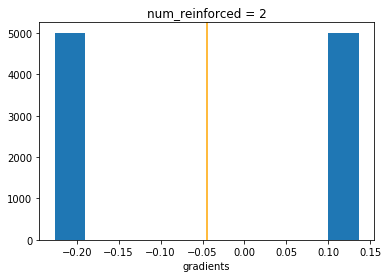

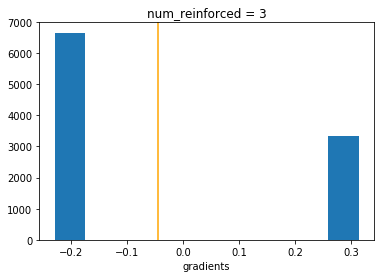

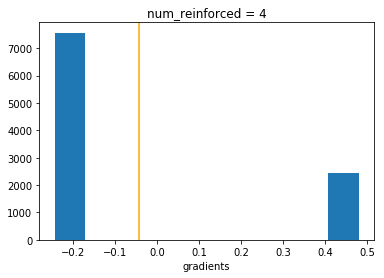

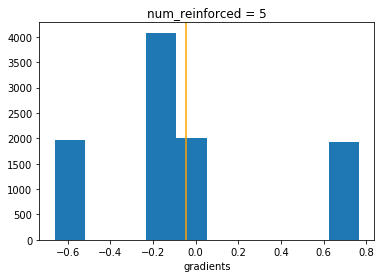

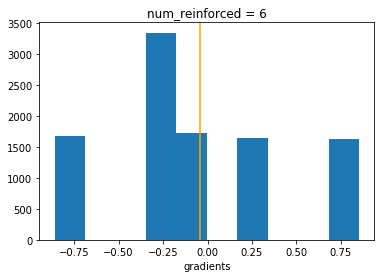

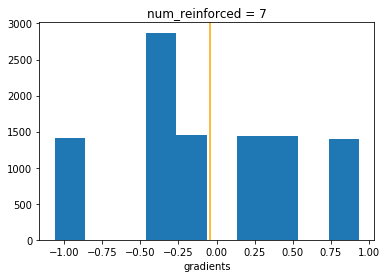

In [20]:
# Lets look at the histogram of the distribution of 
# the gradient estimates

for i in range(1, 2**d): 
    plt.figure()
    plt.hist(mixed_grads_array[i-1, :])
    plt.axvline(x=true_grad, color = 'orange') # true gradient 
    
    plt.title('num_reinforced = {}'.format(i))
    plt.xlabel('gradients')

Text(0.5,0,'num_reinforced')

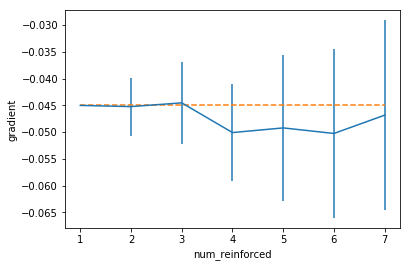

In [21]:
# summarize distribution all on the same plot
# Error bars are 3 * st. error of the distribution 

mixed_grads_means = np.mean(mixed_grads_array.numpy(), axis = 1)
mixed_grads_stds = np.std(mixed_grads_array.numpy(), axis = 1)

plt.errorbar(np.arange(1, 2**d), 
             mixed_grads_means,
             yerr= mixed_grads_stds * 3 / np.sqrt(n_samples))
plt.plot(np.linspace(1, 7), true_grad.numpy() * np.ones(50), '--')

plt.ylabel('gradient')
plt.xlabel('num_reinforced')

In [22]:
mixed_grads_array.shape

torch.Size([7, 10000])

In [23]:
print('variance of reinforce: ', np.var(reinforce_grads.numpy()))
print('variance of arm: ', np.var(arm_grads.numpy()))
print('variance of reinforce-classic mix (num_reinforce = 7):', np.var(mixed_grads_array[-1, ].numpy()))
print('variance of reinforce-classic mix (num_reinforce = 6):', np.var(mixed_grads_array[-2, ].numpy()))


variance of reinforce:  0.44000322
variance of arm:  0.00734981
variance of reinforce-classic mix (num_reinforce = 7): 0.34956318
variance of reinforce-classic mix (num_reinforce = 6): 0.27788612


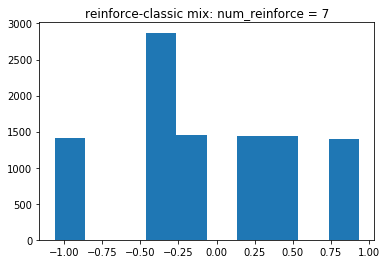

In [24]:
plt.hist(mixed_grads_array[-1, ].numpy()); 
plt.title('reinforce-classic mix: num_reinforce = 7'); 

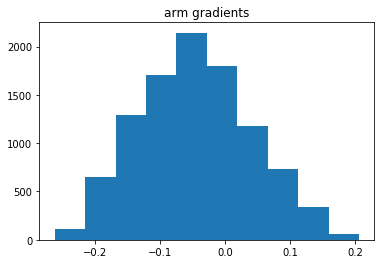

In [25]:
plt.hist(arm_grads.numpy()); 
plt.title('arm gradients'); 

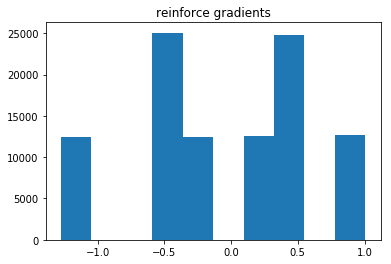

In [26]:
plt.hist(reinforce_grads.numpy()); 
plt.title('reinforce gradients'); 